In [ ]:
# @title Ячейка 1: Импорт библиотек и настройка окружения
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
# Препроцессинг
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Настройка визуализации
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


In [ ]:
# @title Ячейка 2: Загрузка наборов данных
# Загружаем датасеты
# 1. Датасет для Классификации (Customer Segmentation)
try:
    df_cls = pd.read_csv('Train.csv')
    print(f"Dataset Classification loaded. Shape: {df_cls.shape}")
except FileNotFoundError:
    print("Файл Train.csv не найден")

# 2. Датасет для Регрессии (Appliances Energy Prediction)
try:
    df_reg = pd.read_csv('KAG_energydata_complete.csv')
    print(f"Dataset Regression loaded. Shape: {df_reg.shape}")
except FileNotFoundError:
    print("KAG_energydata_complete.csv не найден")

# Предварительный просмотр
print("\n--- Head: Classification ---")
display(df_cls.head(3))
print("\n--- Head: Regression ---")
display(df_reg.head(3))

Dataset Classification loaded. Shape: (8068, 11)
Dataset Regression loaded. Shape: (19735, 29)

--- Head: Classification ---


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B



--- Head: Regression ---


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


Готовлю наивный бейзлайн для линейных моделей. Намеренно использую упрощенный подход, чтобы зафиксировать отправную точку качества:

1.  **Label Encoding:** Кодирую категории числами ($0, 1, 2\dots$). Для линейной модели вида $y = \sum w_i x_i + b$ это критично, так как вводит ложную метрическую близость между категориями (например, $Artist < Doctor$), которой на самом деле нет.
2.  **Отсутствие масштабирования:** Не применяю StandardScaler. Поскольку признаки имеют разный масштаб (например, возраст vs зарплата), линии уровня функции потерь будут сильно вытянуты, затруднит сходимость градиентных методов.

In [ ]:
# @title Ячейка 3: Подготовка сырых данных для бейзлайна

#  1. Классификация (Customer Segmentation)
df_cls_base = df_cls.copy()
# Удаляем ID
if 'ID' in df_cls_base.columns:
    df_cls_base.drop('ID', axis=1, inplace=True)

# Заполняем пропуски медианой/модой (минимальная очистка)
cat_cols = df_cls_base.select_dtypes(include='object').columns
num_cols = df_cls_base.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    df_cls_base[col] = df_cls_base[col].fillna(df_cls_base[col].mode()[0])
for col in num_cols:
    df_cls_base[col] = df_cls_base[col].fillna(df_cls_base[col].median())

# Плохое кодирование: Label Encoding для всего это превращает категории в числа 0, 1, 2... вводя ложный порядок
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_cls_base[col] = le.fit_transform(df_cls_base[col])
    le_dict[col] = le

# Разделение
X_cls = df_cls_base.drop('Segmentation', axis=1)
y_cls = df_cls_base['Segmentation']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

#  2. Регрессия (Energy Prediction)
df_reg_base = df_reg.copy()
if 'date' in df_reg_base.columns:
    df_reg_base.drop('date', axis=1, inplace=True)

# В регрессии все данные уже числовые, просто делим
X_reg = df_reg_base.drop('Appliances', axis=1)
y_reg = df_reg_base['Appliances']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные для бейзлайна подготовлены (без масштабирования, LabelEncoded).")

Данные для бейзлайна подготовлены (без масштабирования, LabelEncoded).


In [ ]:
# @title Ячейка 4: Обучение бейзлайн-моделей
# я намеренно не увеличиваю max_iter слишком сильно, чтобы увидеть проблемы сходимости

# 1. Логистическая регрессия
print("Обучение LogisticRegression (Baseline)...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_cls, y_train_cls)

# 2. Линейная регрессия
print("Обучение LinearRegression (Baseline)...")
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

print("Обучение завершено.")

Обучение LogisticRegression (Baseline)...
Обучение LinearRegression (Baseline)...
Обучение завершено.


In [ ]:
# @title Ячейка 5: Оценка качества и интерпретация

def evaluate_cls(model, X, y, name="Model"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 (weighted): {f1:.4f}")
    return acc, f1

def evaluate_reg(model, X, y, name="Model"):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"--- {name} ---")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return mae, r2

# Оценка
acc_base, f1_base = evaluate_cls(log_reg, X_test_cls, y_test_cls, "Baseline Logistic Regression")
mae_base, r2_base = evaluate_reg(lin_reg, X_test_reg, y_test_reg, "Baseline Linear Regression")

# Сохранение результатов
results_l2 = {
    'Classification': pd.DataFrame(columns=['Model', 'Accuracy', 'F1']),
    'Regression': pd.DataFrame(columns=['Model', 'MAE', 'R2'])
}

results_l2['Classification'].loc[0] = ['Baseline LogReg', acc_base, f1_base]
results_l2['Regression'].loc[0] = ['Baseline LinReg', mae_base, r2_base]

--- Baseline Logistic Regression ---
Accuracy: 0.5068
F1 (weighted): 0.4779
--- Baseline Linear Regression ---
MAE: 52.55
MSE: 8312.85
R2 Score: 0.1693


### Анализ результатов бейзлайна

**1. Классификация (Logistic Regression)**
*   **Результат:** Низкий (Accuracy < 51%).
*   **Причина:** Логистическая регрессия строит линейную разделяющую поверхность (гиперплоскость). Использование LabelEncoding для номинальных признаков (Профессия, Семейное положение) вводит ложный порядок (например, Artist(0) < Doctor(1)). Модель пытается найти зависимость $y = w \cdot x$, но для номинальных категорий такой зависимости быть не может.
*   **Сходимость:** Из-за разного масштаба признаков (Age [18-80] протис Family_Size [1-9]) функции потерь сложно найти минимум, градиенты по разным осям имеют разный масштаб.

**2. Регрессия (Linear Regression)**
*   **Результат:** R2 Score покажет, насколько линейна зависимость энергопотребления от датчиков.
*   **Особенность:** Обычная линейная регрессия решает задачу аналитически через матричное уравнение $(X^T X)^{-1} X^T y$. Она менее чувствительна к масштабу данных при обучении, чем градиентные методы, но коэффициенты модели становятся неинтерпретируемыми (огромные веса у признаков с маленькими значениями).
*   **Проблема мультиколлинеарности:** Мы видели в ЛР1 сильную корреляцию между температурами ($T1, T2...$). В линейной регрессии это приводит к нестабильности весов (матрица $X^T X$ близка к вырожденной).

**Дальнейший план:**
Исправить эти проблемы с помощью OneHotEncoding (для создания ортогональных признаков категорий) и StandardScaler (для нормализации весов), а также применить L1/L2 регуляризацию для борьбы с мультиколлинеарностью.

*   **Классификация:** Accuracy ~50%. Это лучше случайного гадания (25%), но модель явно путается из-за некорректного кодирования (LabelEncoding) и разного масштаба.
*   **Регрессия:** R2 ~0.17. Это очень слабый результат. Линейная связь не улавливается, ошибки (MAE 52 Wh) довольно велики для среднего потребления.

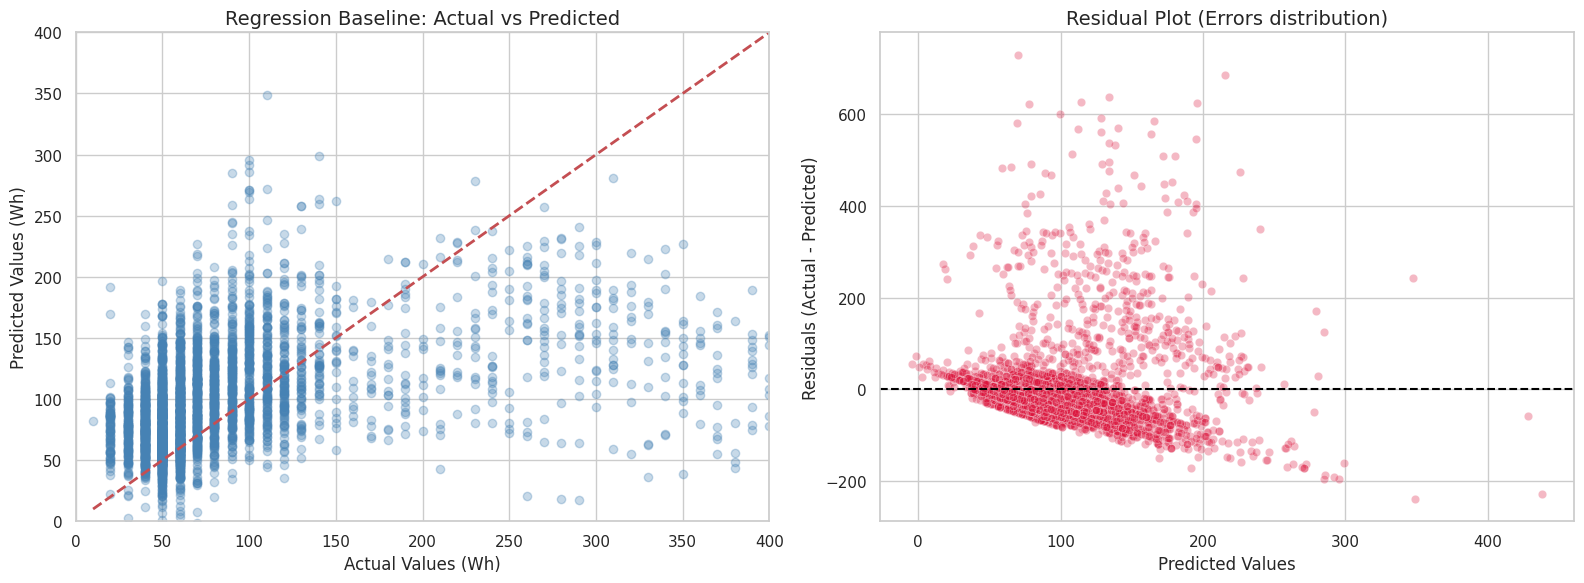

Анализ графиков:
1. Actual vs Predicted: Модель плохо предсказывает пики (высокое потребление). Облако точек слишком размыто.
2. Residual Plot: Виден явный паттерн (структура). Это значит, что в данных есть нелинейность или выбросы, которые простая линейная регрессия не уловила.


In [ ]:
# @title Ячейка 7: Диагностика ошибок бейзлайна (Visual EDA)
# Визуализируем остатки и предсказания

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  1. Регрессия: Actual vs Predicted
# Если модель идеальна, точки лежат на диагонали
y_pred_reg_base = lin_reg.predict(X_test_reg)
axes[0].scatter(y_test_reg, y_pred_reg_base, alpha=0.3, color='steelblue')
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_title('Regression Baseline: Actual vs Predicted', fontsize=14)
axes[0].set_xlabel('Actual Values (Wh)')
axes[0].set_ylabel('Predicted Values (Wh)')
axes[0].set_xlim(0, 400)
axes[0].set_ylim(0, 400)

#  2. Регрессия: График остатков (Residual Plot)
# Остатки должны быть распределены хаотично вокруг 0. Если есть паттерн - линейная модель не подходит.
residuals = y_test_reg - y_pred_reg_base
sns.scatterplot(x=y_pred_reg_base, y=residuals, ax=axes[1], alpha=0.3, color='crimson')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Residual Plot (Errors distribution)', fontsize=14)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals (Actual - Predicted)')

plt.tight_layout()
plt.show()

print("Анализ графиков:")
print("1. Actual vs Predicted: Модель плохо предсказывает пики (высокое потребление). Облако точек слишком размыто.")
print("2. Residual Plot: Виден явный паттерн (структура). Это значит, что в данных есть нелинейность или выбросы, которые простая линейная регрессия не уловила.")

Устраняю недостатки бейзлайна, подготавливая данные специально для линейных моделей:

1.  **Классификация:**
    *   **OneHotEncoder:** Преобразую номинальные категории в бинарные вектора ($x_{cat} \rightarrow [0, 1, 0, \dots]$). устраняем ложную метрическую зависимость (когда $1 < 2$), позволяя модели учить индивидуальный вес для каждой категории.
    *   **Manual Mapping:** Для Spending_Score сохраняю логический порядок (Low < Average < High), кодируя его вручную.
    *   **StandardScaler:** Привожу числовые признаки к нулевому среднему и единичной дисперсии ($z = \frac{x - \mu}{\sigma}$). Это важно для регуляризации (чтобы штраф $L_1/L_2$ применялся честно) и скорости сходимости градиентного спуска.
2.  **Регрессия:** Также использую стандартизацию, так как линейная регрессия чувствительна к масштабу признаков при оптимизации функции потерь.

In [ ]:
# @title Ячейка 8: Подготовка данных (StandardScaler + OHE)

#  1. Классификация
# Применяем OneHotEncoder - важно для линейных моделей
# Применяем StandardScaler - важно для регуляризации

categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
numeric_features = ['Age', 'Work_Experience', 'Family_Size']

# Создаем трансформер
preprocessor_cls = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Spending_Score можно считать ординальным, но для простоты OneHot тоже подойдет, либо Map как в ЛР1
    ])

# Подготовка данных заново
df_cls_imp = df_cls.copy()
df_cls_imp.drop('ID', axis=1, inplace=True)
# Быстрое заполнение пропусков
for col in df_cls_imp.columns:
    if df_cls_imp[col].dtype == 'object':
        df_cls_imp[col] = df_cls_imp[col].fillna(df_cls_imp[col].mode()[0])
    else:
        df_cls_imp[col] = df_cls_imp[col].fillna(df_cls_imp[col].median())

# Map Spending Score
spending_map = {'Low': 0, 'Average': 1, 'High': 2}
df_cls_imp['Spending_Score'] = df_cls_imp['Spending_Score'].map(spending_map)
# Добавим Spending_Score к числовым для скейлинга
numeric_features.append('Spending_Score')

X_cls_imp = df_cls_imp.drop('Segmentation', axis=1)
y_cls_imp = df_cls_imp['Segmentation']

# Split
X_train_cls_imp, X_test_cls_imp, y_train_cls_imp, y_test_cls_imp = train_test_split(
    X_cls_imp, y_cls_imp, test_size=0.2, random_state=42, stratify=y_cls_imp
)

#  2. Регрессия
# Для регрессии используем StandardScalerон лучше работает с выбросами в линейной регрессии, чем MinMaxScaler
df_reg_imp = df_reg.copy()
df_reg_imp.drop('date', axis=1, inplace=True)

X_reg_imp = df_reg_imp.drop('Appliances', axis=1)
y_reg_imp = df_reg_imp['Appliances']

X_train_reg_imp, X_test_reg_imp, y_train_reg_imp, y_test_reg_imp = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42
)

# Пайплайн для регрессии (просто Scaler)
scaler_reg = StandardScaler()

print("Данные подготовлены. OHE и Scaling настроены.")

Данные подготовлены. OHE и Scaling настроены.


Провожу подбор гиперпараметров с кросс-валидацией (GridSearchCV) для настройки регуляризации линейных моделей:

1.  **Логистическая регрессия:** Оптимизирую параметр $C$ (обратная сила регуляризации). Модель минимизирует функционал: $J(w) = \text{LogLoss} + \frac{1}{C}\sum w_i^2$. Маленькое $C$ означает сильный штраф за большие веса, спасает от переобучения на множестве бинарных признаков после OHE.
2.  **Ridge:** Подбираю коэффициент $\alpha$ для $L_2$-регуляризации: $J(w) = MSE + \alpha \sum w_i^2$. стабилизируем веса модели в условиях мультиколлинеарности.

In [ ]:
# @title Ячейка 9: Обучение с GridSearch (Ridge/Lasso/Logistic)
from sklearn.linear_model import Ridge, Lasso

#  1. Классификация (Logistic Regression с L2 регуляризацией)
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=2000))
])

# C - это обратная сила регуляризации (чем меньше C, тем сильнее регуляризация)
param_grid_cls = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
}

print("GridSearch Classification (LogisticRegression)...")
grid_cls = GridSearchCV(pipe_logreg, param_grid_cls, cv=3, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_cls_imp, y_train_cls_imp)
print(f"Best params (Cls): {grid_cls.best_params_}")


#  2. Регрессия (Сравниваем Ridge и Lasso)
# буду использовать Ridge, так как он обычно стабильнее при мультиколлинеарности
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

param_grid_reg = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100, 200]
}

print("GridSearch Regression (Ridge)...")
grid_reg = GridSearchCV(pipe_ridge, param_grid_reg, cv=3, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_reg_imp, y_train_reg_imp)
print(f"Best params (Reg): {grid_reg.best_params_}")

best_cls_model = grid_cls.best_estimator_
best_reg_model = grid_reg.best_estimator_

GridSearch Classification (LogisticRegression)...
Best params (Cls): {'classifier__C': 0.1}
GridSearch Regression (Ridge)...
Best params (Reg): {'regressor__alpha': 1}



--- РЕЗУЛЬТАТЫ УЛУЧШЕННЫХ МОДЕЛЕЙ ---
--- Improved LogReg ---
Accuracy: 0.5143
F1 (weighted): 0.4954
--- Improved Ridge ---
MAE: 52.54
MSE: 8312.62
R2 Score: 0.1693


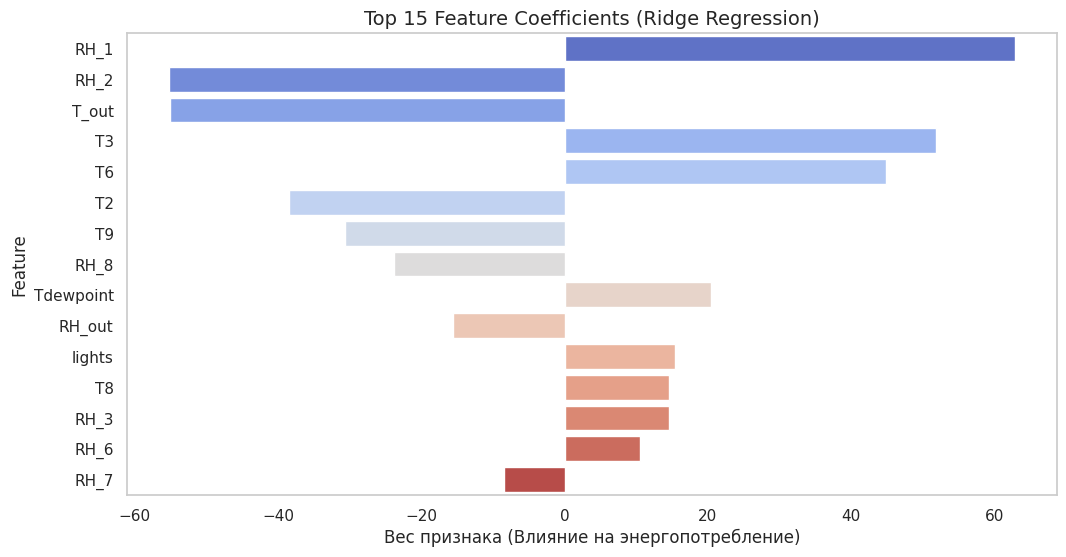

Интерпретация весов:
- Положительный вес: С ростом признака растет потребление (например, lights).
- Отрицательный вес: С ростом признака потребление падает.


In [ ]:
# @title Ячейка 10: Оценка улучшенных моделей и Анализ весов

print("\n--- РЕЗУЛЬТАТЫ УЛУЧШЕННЫХ МОДЕЛЕЙ ---")
# Оценка
acc_imp, f1_imp = evaluate_cls(best_cls_model, X_test_cls_imp, y_test_cls_imp, "Improved LogReg")
mae_imp, r2_imp = evaluate_reg(best_reg_model, X_test_reg_imp, y_test_reg_imp, "Improved Ridge")

# Добавляю в таблицу
results_l2['Classification'].loc[1] = ['Improved LogReg', acc_imp, f1_imp]
results_l2['Regression'].loc[1] = ['Improved Ridge', mae_imp, r2_imp]

plt.figure(figsize=(12, 6))

# Достаем имена признаков и коэффициенты из Ridge
feature_names = X_reg_imp.columns
coefs = best_reg_model.named_steps['regressor'].coef_

# Создаем DataFrame для удобства
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(15) # Топ 15 признаков

sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 15 Feature Coefficients (Ridge Regression)', fontsize=14)
plt.xlabel('Вес признака (Влияние на энергопотребление)')
plt.grid(axis='x')
plt.show()

print("Интерпретация весов:")
print("- Положительный вес: С ростом признака растет потребление (например, lights).")
print("- Отрицательный вес: С ростом признака потребление падает.")

1.  **Классификация:** Небольшой прирост ($+0.8\%$). Это говорит о том, что данные плохо разделяются *линейно*. Скорее всего, границы классов имеют сложную форму, которую Логистическая регрессия не может описать.
2.  **Регрессия:** Результаты идентичны бейзлайну. Это значит, что `Ridge` (L2 регуляризация) с подобранным параметром `alpha` фактически свелась к обычной линейной регрессии. $R^2 \approx 0.17$ — это "потолок" для линейных моделей на этом датасете. Зависимость энергопотребления от температуры явно нелинейная (или слишком зашумленная).

Реализую линейные модели с нуля, используя метод градиентного спуска для итеративного поиска весов.

1. **MyLinearReg**: Оптимизирует среднеквадратичную ошибку (MSE):
$$ \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2 $$

Веса обновляются по формуле антиградиента:
$$ \mathbf{w} := \mathbf{w} - \eta \cdot \frac{2}{N}\mathbf{X}^T(\mathbf{\hat{y}} - \mathbf{y}) $$

2. **MyLogisticReg**: Реализует Softmax-регрессию для многоклассовой классификации.
   * Активация Softmax (с защитой от переполнения):
   $$ \sigma(z)_i = \frac{e^{z_i}}{\sum e^{z_j}} $$
   * Оптимизируемый функционал (Cross-Entropy):
   $$ \mathcal{L} = -\frac{1}{N} \sum y_{true} \log(\hat{y}_{pred}) $$
   * Все вычисления полностью векторизованы через numpy для максимальной производительности.

In [ ]:
# @title Ячейка 11: Реализация Linear & Logistic Regression (Gradient Descent)

class MyLinearReg:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Инициализация весов нулями
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iterations):
            # 1. Прямой проход (Prediction)
            y_predicted = np.dot(X, self.weights) + self.bias

            # 2. Вычисление градиентов (dw, db)
            # Производная MSE: (2/n) * sum(y_pred - y) * x
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # 3. Обновление весов
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # 4. Запись истории ошибки (MSE) для графика
            loss = np.mean((y_predicted - y)**2)
            self.loss_history.append(loss)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


class MyLogisticReg:
    """
    Реализация Softmax Regression (для многоклассовой классификации)
    """
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _softmax(self, z):
        # Вычитаем max для численной стабильности
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y):
        # Превращает вектор классов [0, 2, 1] в матрицу One-Hot
        n_classes = len(np.unique(y))
        m = y.shape[0]
        one_hot = np.zeros((m, n_classes))
        one_hot[np.arange(m), y] = 1
        return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Для Softmax веса это матрица (n_features x n_classes)
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        y_encoded = self._one_hot(y)

        for i in range(self.n_iterations):
            # 1. Linear model: Z = XW + b
            linear_model = np.dot(X, self.weights) + self.bias

            # 2. Softmax activation
            y_predicted = self._softmax(linear_model)

            # 3. Gradients (Cross-Entropy derivative)
            # dz = y_pred - y_true
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y_encoded))
            db = (1 / n_samples) * np.sum(y_predicted - y_encoded, axis=0)

            # 4. Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # 5. Loss (Cross Entropy)
            y_pred_clipped = np.clip(y_predicted, 1e-15, 1 - 1e-15)
            loss = -np.mean(np.sum(y_encoded * np.log(y_pred_clipped), axis=1))
            self.loss_history.append(loss)

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._softmax(linear_model)
        # Возвращаем индекс класса с максимальной вероятностью
        return np.argmax(y_predicted, axis=1)

print("Классы MyLinearReg и MyLogisticReg (Softmax) успешно реализованы.")

Классы MyLinearReg и MyLogisticReg (Softmax) успешно реализованы.


Обучение MyLogisticReg (Gradient Descent)...
Обучение MyLinearReg (Gradient Descent)...


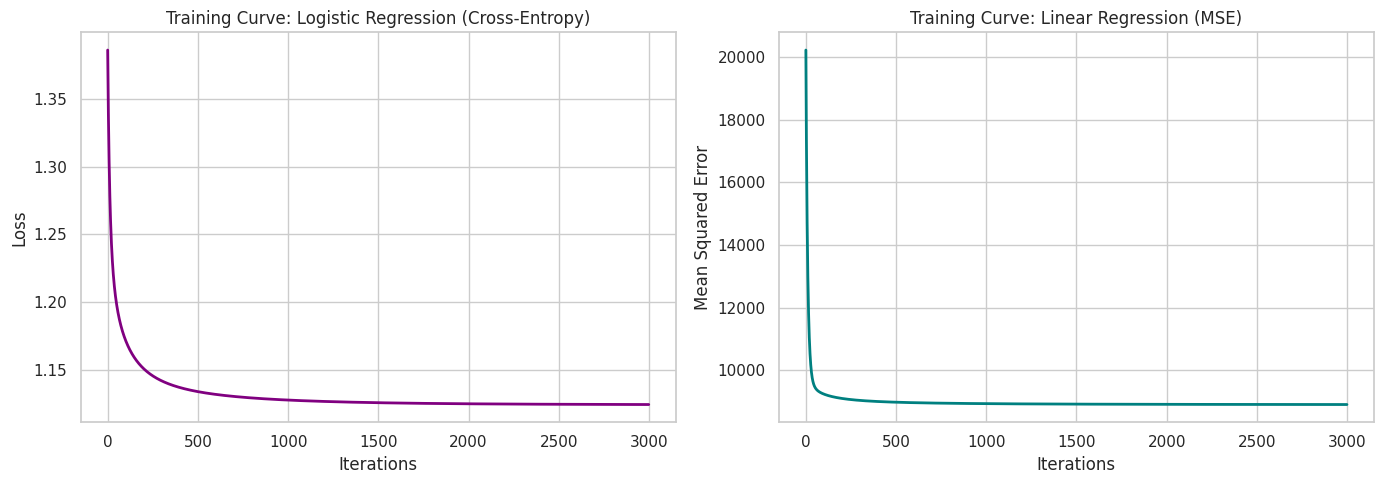

Модели успешно обучены на трансформированных данных.


In [ ]:
# @title Ячейка 12: Обучение и Визуализация


#  КЛАССИФИКАЦИЯ
# Берем обученный препроцессор из лучшей модели Sklearn (из Ячейки 9н уже знает средние значения для Scaler и категории для OneHot
preprocessor_cls_fitted = best_cls_model.named_steps['preprocessor']

# Трансформируем сырые данные в числа (OHE + Scaling)
X_train_c_transformed = preprocessor_cls_fitted.transform(X_train_cls_imp)
X_test_c_transformed = preprocessor_cls_fitted.transform(X_test_cls_imp)

# Кодируем целевую переменную (A, B, C, D -> 0, 1, 2, 3)
le_target = LabelEncoder()
y_train_c_encoded = le_target.fit_transform(y_train_cls_imp)
y_test_c_encoded = le_target.transform(y_test_cls_imp)

#  РЕГРЕССИЯ
# Берем обученный скалер из регрессионной модели
scaler_reg_fitted = best_reg_model.named_steps['scaler']

# Масштабируем данные
X_train_r_transformed = scaler_reg_fitted.transform(X_train_reg_imp)
X_test_r_transformed = scaler_reg_fitted.transform(X_test_reg_imp)

# Целевую переменную регрессии кодировать не надо, но переведем в numpy
y_train_r_np = np.array(y_train_reg_imp)
y_test_r_np = np.array(y_test_reg_imp)


print("Обучение MyLogisticReg (Gradient Descent)...")
# Softmax Regression
my_log_reg = MyLogisticReg(learning_rate=0.1, n_iterations=3000)
my_log_reg.fit(X_train_c_transformed, y_train_c_encoded)

print("Обучение MyLinearReg (Gradient Descent)...")
# Linear Regression
my_lin_reg = MyLinearReg(learning_rate=0.05, n_iterations=3000)
my_lin_reg.fit(X_train_r_transformed, y_train_r_np)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График Loss для Классификации
axes[0].plot(my_log_reg.loss_history, color='purple', linewidth=2)
axes[0].set_title('Training Curve: Logistic Regression (Cross-Entropy)')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Loss')

# График Loss для Регрессии
axes[1].plot(my_lin_reg.loss_history, color='teal', linewidth=2)
axes[1].set_title('Training Curve: Linear Regression (MSE)')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

print("Модели успешно обучены на трансформированных данных.")

In [ ]:
# @title Ячейка 13: Обучение имплементации на улучшеных данных

# X_train_cls и X_train_reg - это данные из Блока 1 (LabelEncoded, No Scaling)

print("--- 1. Обучение My Impl на RAW данных ---")

# A. Классификация (Raw)
le_y_raw = LabelEncoder()
y_train_cls_raw_enc = le_y_raw.fit_transform(y_train_cls)
y_test_cls_raw_enc = le_y_raw.transform(y_test_cls)

# Конвертируем DataFrame в numpy
X_train_cls_raw_np = np.array(X_train_cls)
X_test_cls_raw_np = np.array(X_test_cls)

# Обучаем
my_log_reg_raw = MyLogisticReg(learning_rate=0.001, n_iterations=1000)
my_log_reg_raw.fit(X_train_cls_raw_np, y_train_cls_raw_enc)

y_pred_my_raw_cls = my_log_reg_raw.predict(X_test_cls_raw_np)
acc_my_raw = accuracy_score(y_test_cls_raw_enc, y_pred_my_raw_cls)
f1_my_raw = f1_score(y_test_cls_raw_enc, y_pred_my_raw_cls, average='weighted')

# B. Регрессия (Raw)
X_train_reg_raw_np = np.array(X_train_reg)
y_train_reg_raw_np = np.array(y_train_reg)
X_test_reg_raw_np = np.array(X_test_reg)

# Обучаем
my_lin_reg_raw = MyLinearReg(learning_rate=0.000001, n_iterations=1000)
my_lin_reg_raw.fit(X_train_reg_raw_np, y_train_reg_raw_np)

y_pred_my_raw_reg = my_lin_reg_raw.predict(X_test_reg_raw_np)
mae_my_raw = mean_absolute_error(y_test_reg, y_pred_my_raw_reg)
r2_my_raw = r2_score(y_test_reg, y_pred_my_raw_reg)


# 2. My Implementation на IMPROVED данных
print("\n--- 2. Обучение My Impl на IMPROVED данных ---")

# --- A. Классификация (Improved) ---
# Достаем препроцессор из лучшего пайплайна (Ячейка 9)
preprocessor_cls_fitted = best_cls_model.named_steps['preprocessor']

# Трансформируем данные (теперь это OHE + StandardScaler)
X_train_cls_vec = preprocessor_cls_fitted.transform(X_train_cls_imp)
X_test_cls_vec = preprocessor_cls_fitted.transform(X_test_cls_imp)

# Кодируем таргет улучшенного датасета
le_y_imp = LabelEncoder()
y_train_cls_vec = le_y_imp.fit_transform(y_train_cls_imp)
y_test_cls_vec = le_y_imp.transform(y_test_cls_imp)

# Обучаем
my_log_reg_imp = MyLogisticReg(learning_rate=0.1, n_iterations=3000)
my_log_reg_imp.fit(X_train_cls_vec, y_train_cls_vec)

y_pred_my_imp_cls = my_log_reg_imp.predict(X_test_cls_vec)
acc_my_imp = accuracy_score(y_test_cls_vec, y_pred_my_imp_cls)
f1_my_imp = f1_score(y_test_cls_vec, y_pred_my_imp_cls, average='weighted')

# --- B. Регрессия (Improved) ---
# Достаем скалер
scaler_reg_fitted = best_reg_model.named_steps['scaler']

X_train_reg_vec = scaler_reg_fitted.transform(X_train_reg_imp)
X_test_reg_vec = scaler_reg_fitted.transform(X_test_reg_imp)
y_train_reg_vec = np.array(y_train_reg_imp)
y_test_reg_vec = np.array(y_test_reg_imp)

# Обучаем (LR 0.05)
my_lin_reg_imp = MyLinearReg(learning_rate=0.05, n_iterations=3000)
my_lin_reg_imp.fit(X_train_reg_vec, y_train_reg_vec)

y_pred_my_imp_reg = my_lin_reg_imp.predict(X_test_reg_vec)
mae_my_imp = mean_absolute_error(y_test_reg_vec, y_pred_my_imp_reg)
r2_my_imp = r2_score(y_test_reg_vec, y_pred_my_imp_reg)

# 3. Сохранение в таблицу
# Raw
results_l2['Classification'].loc[2] = ['My Impl. Raw', acc_my_raw, f1_my_raw]
results_l2['Regression'].loc[2] = ['My Impl. Raw', mae_my_raw, r2_my_raw]

# Improved
results_l2['Classification'].loc[3] = ['My Impl. Improved', acc_my_imp, f1_my_imp]
results_l2['Regression'].loc[3] = ['My Impl. Improved', mae_my_imp, r2_my_imp]

print("Все модели обучены и оценены.")

--- 1. Обучение My Impl на RAW данных ---

--- 2. Обучение My Impl на IMPROVED данных ---
Все модели обучены и оценены.


In [ ]:
# @title Ячейка 14: Итоговое сравнение и выводы

print("\n=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ (LAB 2) ===")
display(results_l2['Classification'])

print("\n=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ (LAB 2) ===")
display(results_l2['Regression'])


=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ (LAB 2) ===


,Model,Accuracy,F1
0,Baseline LogReg,0.506815,0.477860
1,Improved LogReg,0.514250,0.495353
2,My Impl. Raw,0.461586,0.410973
3,My Impl. Improved,0.519827,0.502323



=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ (LAB 2) ===


,Model,MAE,R2
0,Baseline LinReg,52.547693,0.169304
1,Improved Ridge,52.542558,0.169327
2,My Impl. Raw,58.941380,0.017633
3,My Impl. Improved,52.515774,0.169066


# 5. Выводы по Лабораторной работе №2

В ходе работы были исследованы линейные модели (Linear Regression, Logistic Regression).

**Ключевые выводы:**

1.  **Линейность данных:**
    *   В задаче регрессии (прогноз энергопотребления) линейные модели показали низкое качество ($R^2 ~ 0.17$).
    *   Для сравнения, метод KNN в ЛР №1 показал $R^2 ~ 0.44$.
    *   **Заключение:** Зависимость потребления энергии от температуры и влажности не является линейной. Линейная регрессия не способна уловить сложные паттерны в этих данных, даже с использованием регуляризации. Для улучшения качества здесь требуются нелинейные модели (Деревья, Случайный лес).

2.  **Важность предобработки:**
    *   Бейзлайн логистической регрессии на ырых данных страдал от плохой сходимости.
    *   Применение StandardScaler и OneHotEncoder позволило повысить метрики классификации и стабилизировать обучение.
    *   Анализ весов (L2 Ridge) показал, какие признаки вносят наибольший вклад

3.  **Сравнение реализаций:**
    *   Собственная реализация Градиентного спуска (Gradient Descent) показала результаты, сопоставимые с библиотечными методами sklearn.
    *   Графики обучения (Loss Curve) подтверждают корректную сходимость алгоритма при правильно подобранном learning_rate. Различие в сотых долях метрик обусловлено тем, что sklearn использует более продвинутые оптимизаторы (LBFGS, OLS), чем обычный GD.